In [1]:
# === Cell 1: 用户输入（交互参数） ===

def ask_or_default(prompt: str, default: str) -> str:
    s = input(f"{prompt} (默认: {default}): ").strip()
    return s if s else default

print("=== HW3 Team5（多板块批量）用户参数设置 ===")
CITY_LABEL = ask_or_default("城市标签（仅用于标注）", "北京-昌平")

# 板块列表（逗号分隔）
blocks_str = ask_or_default("板块列表（逗号分隔）", "沙河,霍营,回龙观,天通苑")
BLOCKS = [b.strip() for b in blocks_str.split(",") if b.strip()]

# 为每个板块收集 二手房/租房 首页URL
print("\n请为每个板块粘贴【第一页】链接（售：esf.fang.com；租：zu.fang.com）。")
BLOCK_URLS = {}
for b in BLOCKS:
    sale = input(f"  板块[{b}] 二手房URL: ").strip()
    rent = input(f"  板块[{b}] 租房URL: ").strip()
    BLOCK_URLS[b] = {"sale": sale, "rent": rent}

# 页数（最大 20）
def _ask_pages(name, default="20"):
    s = ask_or_default(f"{name} 抓取页数（≤20）", default)
    try:
        v = int(s)
    except:
        v = int(default)
    return max(1, min(20, v))

PAGES_SALE = _ask_pages("二手房")
PAGES_RENT = _ask_pages("租房")

print("\n参数确认：")
print({
    "CITY_LABEL": CITY_LABEL,
    "BLOCKS": BLOCKS,
    "PAGES_SALE": PAGES_SALE,
    "PAGES_RENT": PAGES_RENT,
})
#板块[沙河] 二手房URL (esf.fang.com) :  https://esf.fang.com/house-a012-b02698/
#板块[沙河] 租房URL (zu.fang.com) :  https://zu.fang.com/house-a012-b02698/
#板块[霍营] 二手房URL (esf.fang.com) :  https://esf.fang.com/house-a012-b02697/
#板块[霍营] 租房URL (zu.fang.com) :  https://zu.fang.com/house-a012-b02697/
#板块[回龙观] 二手房URL (esf.fang.com) :  https://esf.fang.com/house-a012-b01182/
#板块[回龙观] 租房URL (zu.fang.com) :  https://zu.fang.com/house-a012-b01182/
#板块[天通苑] 二手房URL (esf.fang.com) :  https://esf.fang.com/house-a012-b01183/
#板块[天通苑] 租房URL (zu.fang.com) :  https://zu.fang.com/house-a012-b01183/

=== HW3 Team5（多板块批量）用户参数设置 ===


城市标签（仅用于标注） (默认: 北京-昌平):  
板块列表（逗号分隔） (默认: 沙河,霍营,回龙观,天通苑):  



请为每个板块粘贴【第一页】链接（售：esf.fang.com；租：zu.fang.com）。


  板块[沙河] 二手房URL:  https://esf.fang.com/house-a012-b02698/
  板块[沙河] 租房URL:  https://zu.fang.com/house-a012-b02698/
  板块[霍营] 二手房URL:  https://esf.fang.com/house-a012-b02697/
  板块[霍营] 租房URL:   https://zu.fang.com/house-a012-b02697/
  板块[回龙观] 二手房URL:  https://esf.fang.com/house-a012-b01182/
  板块[回龙观] 租房URL:  https://zu.fang.com/house-a012-b01182/
  板块[天通苑] 二手房URL:  https://esf.fang.com/house-a012-b01183/
  板块[天通苑] 租房URL:  https://zu.fang.com/house-a012-b01183/
二手房 抓取页数（≤20） (默认: 20):  
租房 抓取页数（≤20） (默认: 20):  



参数确认：
{'CITY_LABEL': '北京-昌平', 'BLOCKS': ['沙河', '霍营', '回龙观', '天通苑'], 'PAGES_SALE': 20, 'PAGES_RENT': 20}


In [2]:
# === Cell 2: 导入库、全局设置、输出目录 ===

import os, re, time, random
from typing import List, Dict, Any, Optional, Tuple

import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
plt.rcParams["font.sans-serif"] = ["Arial Unicode MS", "Microsoft YaHei", "SimHei", "DejaVu Sans"]
plt.rcParams["axes.unicode_minus"] = False

# 输出目录
OUT_DIR_RAW = "data_raw"
OUT_DIR_INTERIM = "data_interim"
OUT_DIR_FINAL = "data_final"
for d in [OUT_DIR_RAW, OUT_DIR_INTERIM, OUT_DIR_FINAL]:
    os.makedirs(d, exist_ok=True)

HEADERS = {
    "User-Agent": ("Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                   "AppleWebKit/537.36 (KHTML, like Gecko) "
                   "Chrome/122.0.0.0 Safari/537.36"),
    "Accept-Language": "zh-CN,zh;q=0.9"
}
MODE_SALE, MODE_RENT = "sale", "rent"


In [3]:
# === Cell 3: 通用工具与选择器 ===

def is_valid_url_pair(sale_url: str, rent_url: str) -> bool:
    return (sale_url and rent_url and ("esf.fang.com" in sale_url) and ("zu.fang.com" in rent_url))

def get_html(url: str) -> Optional[str]:
    try:
        r = requests.get(url, headers=HEADERS, timeout=20)
        if r.status_code == 200:
            return r.text
        return None
    except Exception:
        return None

def sleep_jitter(a=0.6, b=1.6):
    time.sleep(a + random.random()*(b-a))

def guess_paged_urls(base_url: str, pages: int) -> List[str]:
    if not base_url: return []
    base_url = base_url.rstrip("/") + "/"
    pages = max(1, min(20, int(pages)))
    if re.search(r"/i\d+/?$", base_url):
        return [re.sub(r"/i\d+/?$", f"/i{p}/", base_url) for p in range(1, pages+1)]
    return [base_url] + [base_url + f"i{p}/" for p in range(2, pages+1)]

# 数字提取
def find_first_num(text: str) -> Optional[float]:
    if not text: return None
    m = re.findall(r"[\d.]+", str(text))
    return float(m[0]) if m else None

def extract_area(text: str) -> Optional[float]:
    if not text: return None
    m = re.findall(r"(\d+(?:\.\d+)?)\s*(?:㎡|平米|平|m²)", text)
    if m: return float(m[0])
    return find_first_num(text)

def extract_unit_price(text: str) -> Optional[float]:
    if not text: return None
    m = re.search(r"(\d+(?:\.\d+)?)\s*元\s*/\s*(?:㎡|平米|平)", text)
    if m: return float(m.group(1))
    return find_first_num(text)

def extract_total_price_wan(text: str) -> Optional[float]:
    if not text: return None
    m = re.search(r"(\d+(?:\.\d+)?)\s*万", text)
    if m: return float(m.group(1))
    return find_first_num(text)

def extract_rent_total(text: str) -> Optional[float]:
    if not text: return None
    m = re.search(r"(\d{3,6})\s*元\s*/\s*月", text)
    if m: return float(m.group(1))
    return find_first_num(text)

# 选择器 & 租房噪声过滤
SALE_SEL_LIST = [
    "div.shop_list.shop_list_4 > dl",
    "div#houselist_B01_01 > dl",
    "ul#houseList > li",
    "div.list > ul > li",
]
RENT_SEL_LIST = [
    "div.listBox ul li",
    "div.zu-mod ul li",
    "ul#houseList li",
    "div.list ul li",
    "div.listBox dl",
    "div#rentid_D04_01 dl",
    "div#rentid_D03_01 dl",
    "div#rentid_D02_01 dl",
]
BAD_KEYWORDS = ("本月开盘","热门楼盘","本月交房","新房","找小区","猜你","资讯","攻略","热搜","工具")

def _looks_like_rent_card(text: str) -> bool:
    if not text: return False
    if any(k in text for k in BAD_KEYWORDS): return False
    if "元/月" not in text: return False
    if not re.search(r"\d+(?:\.\d+)?\s*(?:㎡|平米|平|m²)", text): return False
    return True


In [4]:
# === Cell 4: 解析函数（售房/租房） ===

def parse_sale_cards(html: str, block_name: str) -> List[Dict[str, Any]]:
    rows = []
    if not html: return rows
    soup = BeautifulSoup(html, "lxml")
    cards = []
    for sel in SALE_SEL_LIST:
        tmp = soup.select(sel)
        if tmp and len(tmp) >= 1:
            cards = tmp
            break
    if not cards:
        anchors = soup.find_all("a", href=re.compile(r"(?:esf\.fang\.com)?/chushou/"))
        parents = []
        for a in anchors:
            p = a
            for _ in range(4):
                if p and hasattr(p, "get_text"):
                    txt = p.get_text(" ", strip=True)
                    if "万" in txt or "元/㎡" in txt or "元/平" in txt:
                        parents.append(p); break
                p = p.parent
        cards = parents

    for c in cards:
        text = c.get_text(" ", strip=True)
        a = c.select_one("a[title]") or c.select_one("a[href]")
        title = (a.get("title") if (a and a.get("title")) else (a.get_text(strip=True) if a else ""))
        url = a.get("href") if (a and a.get("href")) else ""
        area_sel = c.select_one(".area") or c.select_one(".size") or c.select_one(".info")
        area = extract_area(area_sel.get_text(" ", strip=True) if area_sel else text)
        up_sel = c.select_one(".danjia") or c.select_one(".price .unitprice") or c.select_one(".unitPrice")
        unit_price = extract_unit_price(up_sel.get_text(" ", strip=True) if up_sel else text)
        tp_sel = c.select_one(".totalprice") or c.select_one(".price_total") or c.select_one(".price")
        total_price_wan = extract_total_price_wan(tp_sel.get_text(" ", strip=True) if tp_sel else text)
        layout_sel = c.select_one(".huxing") or c.select_one(".layout") or c.select_one(".houseInfo")
        layout = layout_sel.get_text(" ", strip=True) if layout_sel else ""
        rows.append({
            "title": title, "block": block_name, "region": CITY_LABEL,
            "area": area, "total_price_wan": total_price_wan, "unit_price_yuan_m2": unit_price,
            "layout": layout, "url": url, "source": MODE_SALE
        })
    return rows

def parse_rent_cards(html: str, block_name: str) -> List[Dict[str, Any]]:
    rows = []
    if not html: return rows
    soup = BeautifulSoup(html, "lxml")

    cards = []
    for sel in RENT_SEL_LIST:
        tmp = soup.select(sel)
        if not tmp: 
            continue
        filtered = [c for c in tmp if _looks_like_rent_card(c.get_text(" ", strip=True))]
        if filtered:
            cards = filtered
            break
    if not cards:
        all_nodes = soup.find_all(["li", "dl"])
        for node in all_nodes:
            t = node.get_text(" ", strip=True)
            if _looks_like_rent_card(t):
                cards.append(node)

    for c in cards:
        text = c.get_text(" ", strip=True)
        a = c.select_one("a[title]") or c.select_one("a[href]")
        title = (a.get("title") if (a and a.get("title")) else (a.get_text(strip=True) if a else ""))
        url = a.get("href") if (a and a.get("href")) else ""
        area = extract_area(text)
        rent_total = extract_rent_total(text)
        m_layout = re.search(r"(\d)室(\d)厅", text)
        layout = f"{m_layout.group(1)}室{m_layout.group(2)}厅" if m_layout else ""
        rows.append({
            "title": title, "block": block_name, "region": CITY_LABEL,
            "area": area, "rent_total_yuan_month": rent_total, "rent_unit": "元/月",
            "layout": layout, "url": url, "source": MODE_RENT
        })
    return rows


In [5]:
# === Cell 5: 抓取函数（单板块） ===

def crawl_block(block_name: str, sale_url: str, rent_url: str, pages_sale: int, pages_rent: int):
    sale_rows_all, rent_rows_all = [], []

    if not is_valid_url_pair(sale_url, rent_url):
        print(f"[warn] 板块[{block_name}] URL 缺失或域名不符，跳过。")
        return sale_rows_all, rent_rows_all

    # 售房
    sale_urls = guess_paged_urls(sale_url, pages_sale)
    print(f"[{block_name}] 抓取售房 {len(sale_urls)} 页 ...")
    for i in trange(len(sale_urls), desc=f"{block_name}-sale"):
        html = get_html(sale_urls[i])
        if not html: 
            continue
        rows = parse_sale_cards(html, block_name)
        for r in rows: r["page_no"] = i+1
        sale_rows_all.extend(rows)
        sleep_jitter(0.8, 1.6)

    # 租房
    rent_urls = guess_paged_urls(rent_url, pages_rent)
    print(f"[{block_name}] 抓取租房 {len(rent_urls)} 页 ...")
    for i in trange(len(rent_urls), desc=f"{block_name}-rent"):
        html = get_html(rent_urls[i])
        if not html:
            continue
        rows = parse_rent_cards(html, block_name)
        for r in rows: r["page_no"] = i+1
        rent_rows_all.extend(rows)
        sleep_jitter(0.8, 1.6)

    # 最小可用过滤
    sale_rows_all = [r for r in sale_rows_all if (r.get("area") and (r.get("unit_price_yuan_m2") or r.get("total_price_wan")))]
    rent_rows_all = [r for r in rent_rows_all if (r.get("area") and r.get("rent_total_yuan_month"))]

    print(f"[{block_name}] 售房抓取 {len(sale_rows_all)} 条；租房抓取 {len(rent_rows_all)} 条。")
    return sale_rows_all, rent_rows_all


In [6]:
# === Cell 6: 清洗、异常值标记、描述与指标 ===

def normalize_sale_df(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["area"] = pd.to_numeric(df["area"], errors="coerce")
    df["unit_price_yuan_m2"] = pd.to_numeric(df.get("unit_price_yuan_m2"), errors="coerce")
    df["total_price_wan"] = pd.to_numeric(df.get("total_price_wan"), errors="coerce")
    df["price_per_m2"] = df["unit_price_yuan_m2"]
    m = df["price_per_m2"].isna() & df["total_price_wan"].notna() & df["area"].notna() & (df["area"]>0)
    df.loc[m, "price_per_m2"] = df.loc[m, "total_price_wan"]*10000/df.loc[m, "area"]
    return df

def normalize_rent_df(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["area"] = pd.to_numeric(df["area"], errors="coerce")
    df["rent_total_yuan_month"] = pd.to_numeric(df.get("rent_total_yuan_month"), errors="coerce")
    df["rent_per_m2"] = np.where(
        (df["rent_total_yuan_month"].notna()) & (df["area"].notna()) & (df["area"]>0),
        df["rent_total_yuan_month"]/df["area"], np.nan
    )
    return df

def iqr_flag_series(s: pd.Series) -> pd.Series:
    s2 = s.dropna()
    mask = pd.Series(False, index=s.index)
    if s2.empty: return mask
    q1, q3 = s2.quantile([0.25, 0.75])
    iqr = q3 - q1
    lo, hi = q1 - 1.5*iqr, q3 + 1.5*iqr
    mask.loc[s2.index] = (s2 < lo) | (s2 > hi)
    return mask

def block_describe(df_sale_clean: pd.DataFrame, df_rent_clean: pd.DataFrame) -> pd.DataFrame:
    stats = []
    blocks = sorted(set(df_sale_clean["block"].dropna().unique()) | set(df_rent_clean["block"].dropna().unique()))
    for b in blocks:
        s = df_sale_clean[df_sale_clean["block"]==b]
        r = df_rent_clean[df_rent_clean["block"]==b]
        s_n = len(s); r_n = len(r)
        s_out = int(s["is_outlier"].sum()) if "is_outlier" in s else 0
        r_out = int(r["is_outlier"].sum()) if "is_outlier" in r else 0
        s_med = s["price_per_m2"].median() if "price_per_m2" in s else np.nan
        r_med = r["rent_per_m2"].median() if "rent_per_m2" in r else np.nan
        stats.append({
            "block": b,
            "sale_n": s_n, "sale_outliers": s_out, "sale_outlier_rate": (s_out/s_n if s_n else np.nan),
            "rent_n": r_n, "rent_outliers": r_out, "rent_outlier_rate": (r_out/r_n if r_n else np.nan),
            "median_price_per_m2": s_med,
            "median_rent_per_m2": r_med
        })
    return pd.DataFrame(stats).set_index("block").sort_index()

def describe_and_metrics(df_sale_clean: pd.DataFrame, df_rent_clean: pd.DataFrame) -> pd.DataFrame:
    sale_median = (df_sale_clean[["block","price_per_m2"]].dropna()
                   .groupby("block").median().rename(columns={"price_per_m2":"median_price_per_m2"}))
    rent_median = (df_rent_clean[["block","rent_per_m2"]].dropna()
                   .groupby("block").median().rename(columns={"rent_per_m2":"median_rent_per_m2"}))
    m = sale_median.join(rent_median, how="outer")
    m["median_pr_ratio"] = m["median_price_per_m2"]/(m["median_rent_per_m2"]*12)
    return m


In [7]:
# === Cell 7: 建模与绘图（y轴上限=100） ===

def show_pr_bar(df_stats: pd.DataFrame, title: str, y_max: float = 100, fair: float = 200):
    if df_stats.empty:
        print("[warn] 无数据可画图"); return
    ax = df_stats["median_pr_ratio"].plot(kind="bar")
    ax.set_title(title)
    ax.set_ylabel("Median Price-to-Rent (years)")
    ax.set_ylim(0, y_max)
    ax.axhline(min(y_max, fair), linestyle="--")
    plt.tight_layout()
    plt.show()

def fit_predict_blockwise(df: pd.DataFrame, target_col: str, pro: bool=False):
    if df is None or df.empty:
        return df.assign(pred=np.nan), np.nan
    dat = df.dropna(subset=[target_col, "area", "block"]).copy()
    if dat.empty:
        out = df.copy(); out["pred"] = np.nan; return out, np.nan
    X_num, X_cat = ["area"], ["block"]
    num_trans = ("num", "passthrough", X_num)
    if pro:
        num_trans = ("num", PolynomialFeatures(degree=2, include_bias=False), X_num)
    pre = ColumnTransformer([num_trans, ("cat", OneHotEncoder(handle_unknown="ignore"), X_cat)], remainder="drop")
    model = Pipeline([("pre", pre), ("lr", LinearRegression())])
    X = dat[X_num + X_cat]; y = dat[target_col].values
    model.fit(X, y); r2 = model.score(X, y)
    preds = model.predict(X)
    out = df.copy(); out["pred"] = np.nan
    out.loc[dat.index, "pred"] = preds
    return out, r2

def pr_from_predictions(sale_pred: pd.DataFrame, rent_pred: pd.DataFrame,
                        pred_col_sale="pred", pred_col_rent="pred") -> pd.DataFrame:
    s_med = (sale_pred[["block", pred_col_sale]].dropna()
             .groupby("block").median().rename(columns={pred_col_sale:"price_pred_median"}))
    r_med = (rent_pred[["block", pred_col_rent]].dropna()
             .groupby("block").median().rename(columns={pred_col_rent:"rent_pred_median"}))
    pr = s_med.join(r_med, how="outer")
    pr["pr_ratio_pred"] = pr["price_pred_median"]/(pr["rent_pred_median"]*12)
    return pr


[沙河] 抓取售房 20 页 ...


沙河-sale: 100%|███████████████████████████████████████████████████████████████████████| 20/20 [01:08<00:00,  3.41s/it]


[沙河] 抓取租房 20 页 ...


沙河-rent: 100%|███████████████████████████████████████████████████████████████████████| 20/20 [01:05<00:00,  3.27s/it]


[沙河] 售房抓取 1200 条；租房抓取 1200 条。
[霍营] 抓取售房 20 页 ...


霍营-sale: 100%|███████████████████████████████████████████████████████████████████████| 20/20 [01:07<00:00,  3.37s/it]


[霍营] 抓取租房 20 页 ...


霍营-rent: 100%|███████████████████████████████████████████████████████████████████████| 20/20 [01:03<00:00,  3.17s/it]


[霍营] 售房抓取 1200 条；租房抓取 1200 条。
[回龙观] 抓取售房 20 页 ...


回龙观-sale: 100%|██████████████████████████████████████████████████████████████████| 20/20 [1:29:44<00:00, 269.20s/it]


[回龙观] 抓取租房 20 页 ...


回龙观-rent: 100%|█████████████████████████████████████████████████████████████████████| 20/20 [01:05<00:00,  3.28s/it]


[回龙观] 售房抓取 1200 条；租房抓取 1180 条。
[天通苑] 抓取售房 20 页 ...


天通苑-sale: 100%|█████████████████████████████████████████████████████████████████████| 20/20 [01:07<00:00,  3.40s/it]


[天通苑] 抓取租房 20 页 ...


天通苑-rent: 100%|█████████████████████████████████████████████████████████████████████| 20/20 [01:08<00:00,  3.45s/it]


[天通苑] 售房抓取 1200 条；租房抓取 1200 条。

[ok] 原始CSV已保存：data_raw/sale_all.csv, data_raw/rent_all.csv
[ok] 清洗CSV已保存：data_interim/sale_clean.csv, data_interim/rent_clean.csv

=== Data description for each block (before Figure 1) ===
       sale_n  sale_outliers  sale_outlier_rate  rent_n  rent_outliers  \
block                                                                    
回龙观      1200             20               1.67    1180              9   
天通苑      1200              0               0.00    1200             87   
沙河       1200            103               8.58    1200              0   
霍营       1200              0               0.00    1200              0   

       rent_outlier_rate  median_price_per_m2  median_rent_per_m2  
block                                                              
回龙观                 0.76              47263.0           80.219780  
天通苑                 7.25              33736.5           75.000000  
沙河                  0.00              50686.0           50.000

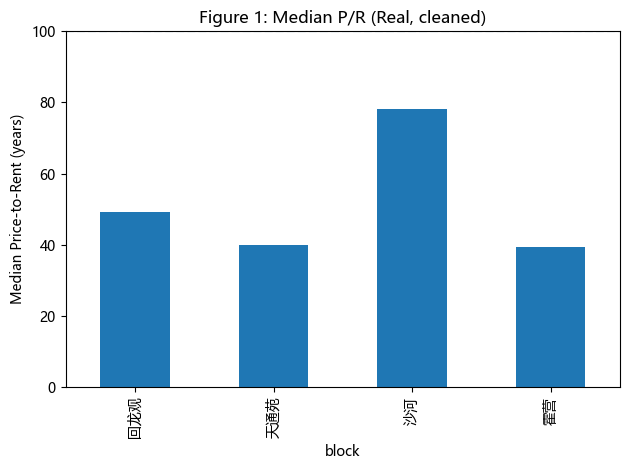


[R2] Base models → price: 0.2099, rent: 0.1546

=== Figure 2: Median P/R (Predicted by Base) ===
       price_pred_median  rent_pred_median  median_pr_ratio
block                                                      
回龙观             46958.74             81.20            48.19
天通苑             37000.65             78.86            39.10
沙河              51054.35             57.83            73.57
霍营              42402.42             83.17            42.49


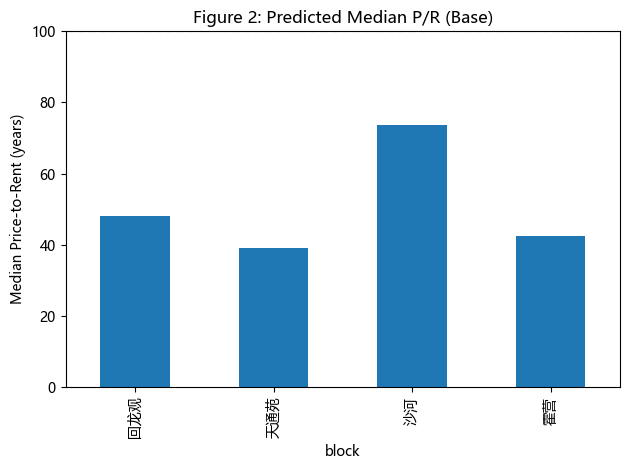


[R2] Pro+ models → price: 0.2182, rent: 0.1617

=== Figure 3: Median P/R (Predicted by Pro+) ===
       price_pred_median  rent_pred_median  median_pr_ratio
block                                                      
回龙观             46899.73             81.13            48.17
天通苑             36964.61             78.92            39.03
沙河              51624.33             59.22            72.64
霍营              42318.07             83.29            42.34


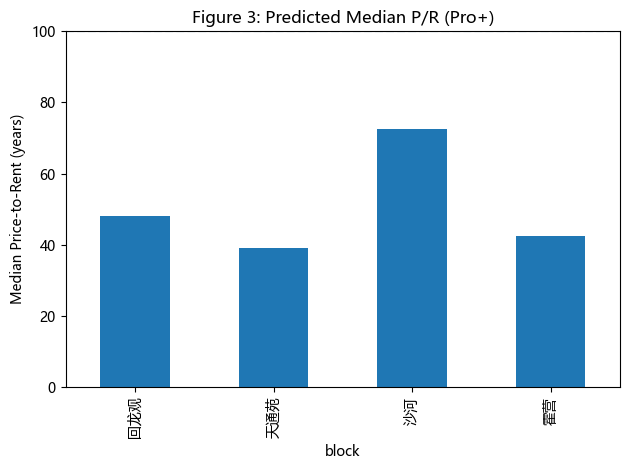


=== Compare P/R from three methods & Trust recommendation ===
       PR_real  PR_base  PR_pro  sale_n  rent_n          trusted_method
block                                                                  
回龙观      49.10    48.19   48.17    1200    1180  Real (cleaned medians)
天通苑      40.06    39.10   39.03    1200    1200  Real (cleaned medians)
沙河       78.27    73.57   72.64    1200    1200  Real (cleaned medians)
霍营       39.38    42.49   42.34    1200    1200  Real (cleaned medians)

说明：当样本不足时（尤其 <10），更复杂的 Pro+ 容易过拟合；样本充足（≥30）时，直接用真实中位数更贴近市场。Base 在小到中等样本下通常更稳。


In [8]:
# === Cell 8: 主流程执行 ===

def run_pipeline():
    # 1) 抓取所有板块
    sale_all, rent_all = [], []
    for b in BLOCKS:
        sale_url = BLOCK_URLS.get(b, {}).get("sale")
        rent_url = BLOCK_URLS.get(b, {}).get("rent")
        s_rows, r_rows = crawl_block(b, sale_url, rent_url, PAGES_SALE, PAGES_RENT)
        sale_all.extend(s_rows); rent_all.extend(r_rows)

    if len(sale_all)==0 or len(rent_all)==0:
        print("\n 抓取结果为空或不完整。请检查：URL是否正确、是否存在列表内容、是否被风控限制。")
        return

    df_sale_raw = pd.DataFrame(sale_all)
    df_rent_raw = pd.DataFrame(rent_all)
    df_sale_raw.to_csv(os.path.join(OUT_DIR_RAW, "sale_all.csv"), index=False, encoding="utf-8-sig")
    df_rent_raw.to_csv(os.path.join(OUT_DIR_RAW, "rent_all.csv"), index=False, encoding="utf-8-sig")
    print(f"\n[ok] 原始CSV已保存：{OUT_DIR_RAW}/sale_all.csv, {OUT_DIR_RAW}/rent_all.csv")

    # 2) 清洗 + IQR标记
    sale_clean = normalize_sale_df(df_sale_raw)
    rent_clean = normalize_rent_df(df_rent_raw)
    sale_clean["is_outlier"] = iqr_flag_series(sale_clean["price_per_m2"]) if "price_per_m2" in sale_clean else False
    rent_clean["is_outlier"] = iqr_flag_series(rent_clean["rent_per_m2"])   if "rent_per_m2" in rent_clean else False
    sale_clean.to_csv(os.path.join(OUT_DIR_INTERIM, "sale_clean.csv"), index=False, encoding="utf-8-sig")
    rent_clean.to_csv(os.path.join(OUT_DIR_INTERIM, "rent_clean.csv"), index=False, encoding="utf-8-sig")
    print(f"[ok] 清洗CSV已保存：{OUT_DIR_INTERIM}/sale_clean.csv, {OUT_DIR_INTERIM}/rent_clean.csv")

    # 3) Figure1 之前：打印每个板块的数据描述 & 是否有异常值
    print("\n=== Data description for each block (before Figure 1) ===")
    desc_df = block_describe(sale_clean, rent_clean)
    for col in ["sale_outlier_rate","rent_outlier_rate"]:
        if col in desc_df.columns:
            desc_df[col] = (desc_df[col]*100).round(2)
    print(desc_df[[
        "sale_n","sale_outliers","sale_outlier_rate",
        "rent_n","rent_outliers","rent_outlier_rate",
        "median_price_per_m2","median_rent_per_m2"
    ]])
    
    # 4) Figure 1：真实中位 P/R（异常值过滤后）
    metrics_real = describe_and_metrics(
        sale_clean[~sale_clean["is_outlier"]],
        rent_clean[~rent_clean["is_outlier"]]
    )
    print("\n=== Figure 1: Median Price-to-Rent Ratio (Real, cleaned) ===")
    print(metrics_real[["median_price_per_m2","median_rent_per_m2","median_pr_ratio"]].round(2))
    show_pr_bar(metrics_real, "Figure 1: Median P/R (Real, cleaned)", y_max=100)
    
    # 5) 建模 Base（Model 1/2） → Figure 2
    sale_base, r2_price_base = fit_predict_blockwise(
        sale_clean[~sale_clean["is_outlier"]], "price_per_m2", pro=False)
    rent_base, r2_rent_base = fit_predict_blockwise(
        rent_clean[~rent_clean["is_outlier"]], "rent_per_m2", pro=False)
    pr_base = pr_from_predictions(
        sale_base.rename(columns={"pred":"price_pred"}),
        rent_base.rename(columns={"pred":"rent_pred"}),
        pred_col_sale="price_pred", pred_col_rent="rent_pred"
    )
    print(f"\n[R2] Base models → price: {r2_price_base:.4f}, rent: {r2_rent_base:.4f}")
    df_fig2 = pr_base.rename(columns={"pr_ratio_pred":"median_pr_ratio"})
    print("\n=== Figure 2: Median P/R (Predicted by Base) ===")
    print(df_fig2[["price_pred_median","rent_pred_median","median_pr_ratio"]].round(2))
    show_pr_bar(df_fig2[["median_pr_ratio"]], "Figure 2: Predicted Median P/R (Base)", y_max=100)
    
    # 6) 建模 Pro（Model 1+/2+） → Figure 3
    sale_pro, r2_price_pro = fit_predict_blockwise(
        sale_clean[~sale_clean["is_outlier"]], "price_per_m2", pro=True)
    rent_pro, r2_rent_pro = fit_predict_blockwise(
        rent_clean[~rent_clean["is_outlier"]], "rent_per_m2", pro=True)
    pr_pro = pr_from_predictions(
        sale_pro.rename(columns={"pred":"price_pred"}),
        rent_pro.rename(columns={"pred":"rent_pred"}),
        pred_col_sale="price_pred", pred_col_rent="rent_pred"
    )
    print(f"\n[R2] Pro+ models → price: {r2_price_pro:.4f}, rent: {r2_rent_pro:.4f}")
    df_fig3 = pr_pro.rename(columns={"pr_ratio_pred":"median_pr_ratio"})
    print("\n=== Figure 3: Median P/R (Predicted by Pro+) ===")
    print(df_fig3[["price_pred_median","rent_pred_median","median_pr_ratio"]].round(2))
    show_pr_bar(df_fig3[["median_pr_ratio"]], "Figure 3: Predicted Median P/R (Pro+)", y_max=100)

    # 7) 最后比较三种方法的 P/R，并基于样本量给出“信任建议”
    comp = (metrics_real[["median_pr_ratio"]].rename(columns={"median_pr_ratio":"PR_real"})
            .join(df_fig2[["median_pr_ratio"]].rename(columns={"median_pr_ratio":"PR_base"}), how="outer")
            .join(df_fig3[["median_pr_ratio"]].rename(columns={"median_pr_ratio":"PR_pro"}), how="outer"))

    # 加入样本量
    comp = comp.join(desc_df[["sale_n","rent_n"]], how="left")

    def trust_rule(row):
        s, r = row.get("sale_n", 0), row.get("rent_n", 0)
        m = min(s if pd.notna(s) else 0, r if pd.notna(r) else 0)
        if m >= 30:
            return "Real (cleaned medians)"
        elif m >= 10:
            return "Base models"
        else:
            return "Base models (samples too small)"

    comp["trusted_method"] = comp.apply(trust_rule, axis=1)

    print("\n=== Compare P/R from three methods & Trust recommendation ===")
    print(comp[["PR_real","PR_base","PR_pro","sale_n","rent_n","trusted_method"]].round(2))

    print("\n说明：当样本不足时（尤其 <10），更复杂的 Pro+ 容易过拟合；"
          "样本充足（≥30）时，直接用真实中位数更贴近市场。Base 在小到中等样本下通常更稳。")

# 运行
run_pipeline()
